In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/train.csv'  # Update with the actual path
df = pd.read_csv(file_path)


def isolate(df):
    df['Date']= pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    store_sales = df.groupby('Store')['Sales'].resample('D').sum().reset_index()
    return store_sales
store_sales= isolate(df)

Mounted at /content/drive


<ipython-input-1-6926fa75631c>:16: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [ ]:
def test_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("The series is non-stationary. Differencing required.")
    else:
        print("The series is stationary.")

#test_stationarity(store_sales[7])


In [ ]:
def create_supervised_data(data, n_step):
    X, y = [], []
    for i in range(len(data) - n_step):
        X.append(data[i:i + n_step])
        y.append(data[i + n_step])
    return np.array(X), np.array(y)

# Define n_step period (e.g., 30 days)
n_step = 30
sales_data = store_sales['Sales'].values
X, y = create_supervised_data(sales_data, n_step)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape[0], X.shape[1], 1)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))
X_train,x_test,y_train,y_test= train_test_split(X_scaled,y_scaled, test_size=0.2, random_state=42)


In [ ]:
model = tf.keras.Sequential()

# LSTM Layer 1
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_scaled.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2))  # Dropout layer to prevent overfitting

# LSTM Layer 2
model.add(tf.keras.layers.LSTM(units=50, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))

# Output layer
model.add(tf.keras.layers.Dense(units=1))


model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_error',
    metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(X_train, y_train, epochs=10)

predictions = model.predict(x_test)

# Invert scaling for predictions and actual values
predictions_rescaled = scaler.inverse_transform(predictions)
y_rescaled = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_rescaled, predictions_rescaled)
rmse = math.sqrt(mse)

print(f"RMSE: {rmse}")



Epoch 1/10
26258/26258 ━━━━━━━━━━━━━━━━━━━━ 854s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0212
Epoch 2/10
26258/26258 ━━━━━━━━━━━━━━━━━━━━ 850s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0074
Epoch 3/10
26258/26258 ━━━━━━━━━━━━━━━━━━━━ 861s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0055
Epoch 4/10
26258/26258 ━━━━━━━━━━━━━━━━━━━━ 870s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0044
Epoch 5/10
26258/26258 ━━━━━━━━━━━━━━━━━━━━ 931s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0040
Epoch 6/10
26258/26258 ━━━━━━━━━━━━━━━━━━━━ 930s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0037
Epoch 7/10
26258/26258 ━━━━━━━━━━━━━━━━━━━━ 928s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0035
Epoch 8/10
26258/26258 ━━━━━━━━━━━━━━━━━━━━ 903s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0034
Epoch 9/10
26258/26258 ━━━━━━━━━━━━━━━━━━━━ 922s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0032
Epoch 10/10
26258/26258 ━━━━━━━━━━━━━━━━━━━━ 878s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0031
6565/6565 ━━━━━━━━━━━━━━━━━━━

"# Compare predictions to actual values\nplt.plot(y_rescaled, label='True Sales')\nplt.plot(predictions_rescaled, label='Predicted Sales')\nplt.legend()\nplt.show()"

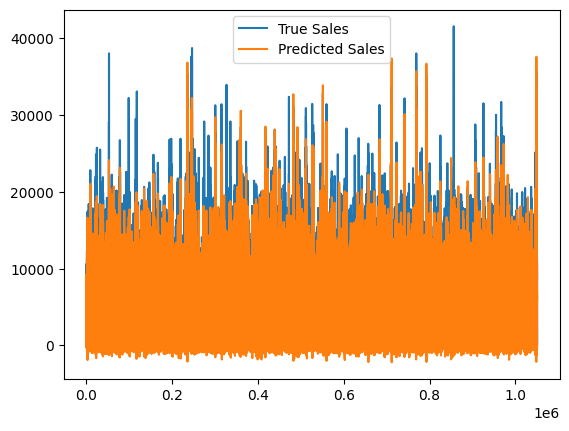

In [ ]:
plt.plot(y_rescaled, label='True Sales')
plt.plot(predictions_rescaled, label='Predicted Sales')
plt.legend()
plt.show()